In [1]:
'''
System Information: 
Operating System: Windows 11 
Processor: 12th Gen Intel(R) Core(TM) i7-12700H 
Architecture: 64bit 
Total Memory: 15.64 GB
'''

'\nSystem Information: \nOperating System: Windows 11 \nProcessor: 12th Gen Intel(R) Core(TM) i7-12700H \nArchitecture: 64bit \nTotal Memory: 15.64 GB\n'

In [2]:
#Naïve approach 
import numpy as np
from numba import njit
import time 
filename = "measurement_data_2024_uint8.bin"
data = np.fromfile(filename, dtype=np.uint8)

@njit
def naive_method(data):
    n = 0
    sum_x = 0.0
    sum_x2 = 0.0
# Iterate over data to calculate sum and sum of squares
    for x in data:
        n += 1
        sum_x += x          
        sum_x2 += x * x     
# Calculate mean and variance
    mean = sum_x / n        
    variance = (sum_x2 / n) - (mean * mean)  

    return mean, variance


start_time = time.time() 
mean, variance = naive_method(data)
end_time = time.time()  

execution_time = end_time - start_time  

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Execution Time: {execution_time:.6f} seconds") 


Mean: 133.700091185
Variance: 1.7878604616889788
Execution Time: 1.492693 seconds


In [3]:
#Welford’s algorithm
import numpy as np
from numba import njit
import time 

filename = "measurement_data_2024_uint8.bin"
data = np.fromfile(filename, dtype=np.uint8)

@njit
def update_batch(data):
    count = 0
    mean = 0.0
    M2 = 0.0

    for new_value in data:
        count += 1
        delta = new_value - mean # Difference between new value and current
        mean += delta / count    # Update mean
        delta2 = new_value - mean
        M2 += delta * delta2

    return count, mean, M2


# Calculate population variance and sample variance
@njit
def finalize_batch(count, mean, M2):
    if count < 2:
        return mean, float('nan'), float('nan')
    else:
        variance = M2 / count  
        sample_variance = M2 / (count - 1)  
        return mean, variance, sample_variance


start_time = time.time() 
count, mean, M2 = update_batch(data)
mean, variance, sample_variance = finalize_batch(count, mean, M2)
end_time = time.time() 

execution_time = end_time - start_time

print(f"Mean : {mean}")
print(f"Variance : {variance}")
print(f"Execution Time: {execution_time} seconds")


Mean : 133.7000911848925
Variance : 1.7878604616782383
Execution Time: 8.626303434371948 seconds


In [4]:
#One-pass arbitrary order method 
import numpy as np
from numba import njit
import time 

@njit
def  One_pass_arbitrary_order_method(data, order=2):  
    n = 0
    mean = 0.0
    central_moments = np.zeros(order + 1)
    
    for value in data:
        delta = value - mean
        n += 1
        mean += delta / n
        factor = (n - 1) / n
        power_delta = delta
        for d in range(1, order + 1):
            central_moments[d] += power_delta * (factor ** (d - 1))
            power_delta *= delta  
    
    for d in range(1, order + 1):
        central_moments[d] /= n  # Normalize central moments
    
    return mean, central_moments[2]   


file_path = "measurement_data_2024_uint8.bin"  
data = np.fromfile(file_path, dtype=np.uint8)

start_time = time.time() 
mean, variance =  One_pass_arbitrary_order_method(data, order=2)
end_time = time.time() 

execution_time = end_time - start_time

print(f"Mean: {mean}")
print(f"Variance : {variance}")
print(f"Execution Time: {execution_time} seconds")


Mean: 133.7000911848925
Variance : 1.7878604616782392
Execution Time: 18.030998945236206 seconds


In [5]:
#Histogram method
import numpy as np
from numba import njit
import time 

filename = "measurement_data_2024_uint8.bin"
data = np.fromfile(filename, dtype=np.uint8)

@njit
def histogram_method(data, labels):
    H0 = np.zeros(256, dtype=np.uint64)
    H1 = np.zeros(256, dtype=np.uint64)

# Update histogram
    for i in range(len(data)):
        if labels[i] == 0:
            H0[data[i]] += 1 
        else:
            H1[data[i]] += 1

   # Calculate mean for H0 histogram
    total_H0 = np.sum(H0)
    mean_H0 = 0.0
    for value in range(256):
        mean_H0 += value * H0[value]
    mean_H0 /= total_H0
    
    # Calculate variance for H0 histogram
    variance_H0 = 0.0
    for value in range(256):
        variance_H0 += H0[value] * (value - mean_H0) ** 2
    variance_H0 /= total_H0

    std_H0 = np.sqrt(variance_H0)
    return mean_H0, variance_H0, std_H0

filename = "measurement_data_2024_uint8.bin"
data = np.fromfile(filename, dtype=np.uint8)

labels = np.random.randint(0, 2, size=len(data))

start_time = time.time() 
mean, variance, std = histogram_method(data, labels)
end_time = time.time() 

execution_time = end_time - start_time

print(f"Histogram Method: Mean : {mean}")
print(f"Variance: {variance}")
print(f"Standard Deviation: {std}")
print(f"Execution Time: {execution_time} seconds")

Histogram Method: Mean : 133.70009891053735
Variance: 1.7876703436624264
Standard Deviation: 1.3370378991122227
Execution Time: 1.6073074340820312 seconds


In [6]:
'''
e)	Compare the runtime of the different methods
Naïve approach ∗ 
Execution Time: 1.396045 seconds

Welford’s algorithm 
Execution Time: 7.194937 seconds

One-pass arbitrary order method 
Execution Time: 6.838472 seconds

Histogram method 
Execution Time: 1.658899 seconds

The Naïve approach outperforms other methods in terms of speed, 
which I think is because its calculation process is relatively simple. 
Although Welford’s algorithm and One-pass arbitrary order method take longer to compute, 
they provide better numerical stability. In contrast, although the Histogram method has a moderate execution time, 
it is not as numerically stable as Welford’s algorithm and One-pass arbitrary order method.

'''

'\ne)\tCompare the runtime of the different methods\nNaïve approach ∗ \nExecution Time: 1.396045 seconds\n\nWelford’s algorithm \nExecution Time: 7.194937 seconds\n\nOne-pass arbitrary order method \nExecution Time: 6.838472 seconds\n\nHistogram method \nExecution Time: 1.658899 seconds\n\nThe Naïve approach outperforms other methods in terms of speed, \nwhich I think is because its calculation process is relatively simple. \nAlthough Welford’s algorithm and One-pass arbitrary order method take longer to compute, \nthey provide better numerical stability. In contrast, although the Histogram method has a moderate execution time, \nit is not as numerically stable as Welford’s algorithm and One-pass arbitrary order method.\n\n'

Execution Time: 8.577806 seconds


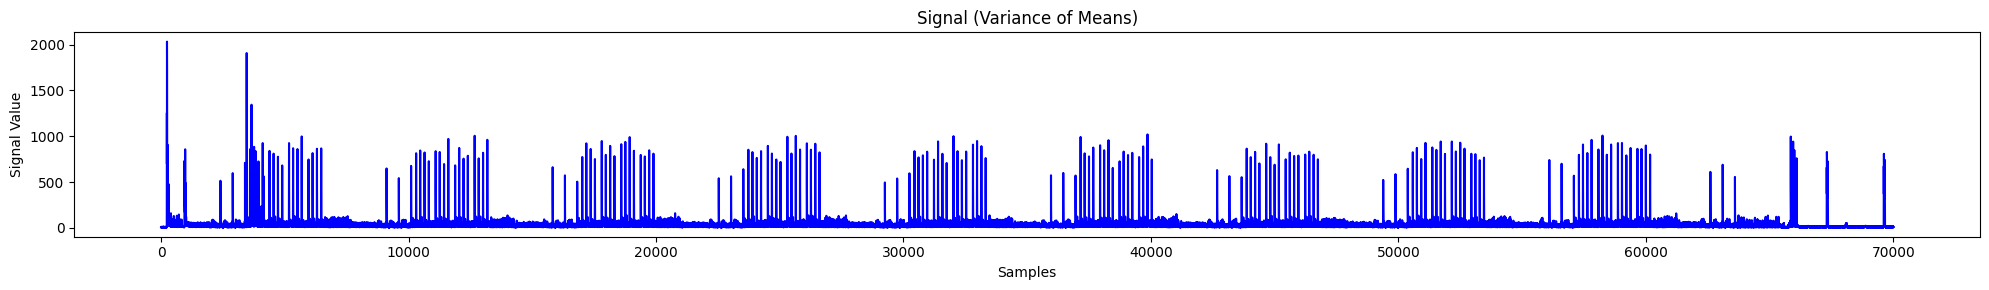

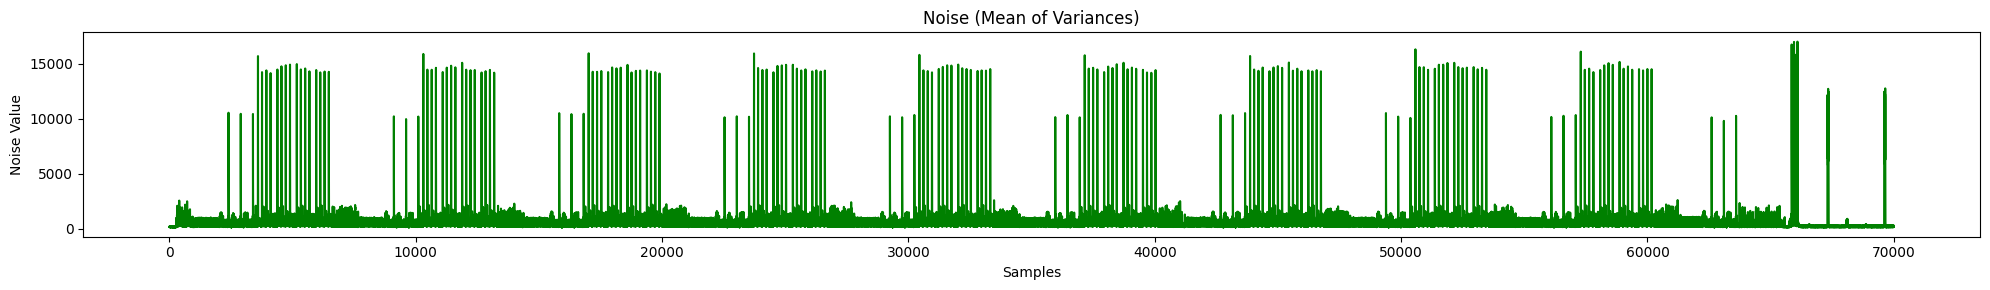

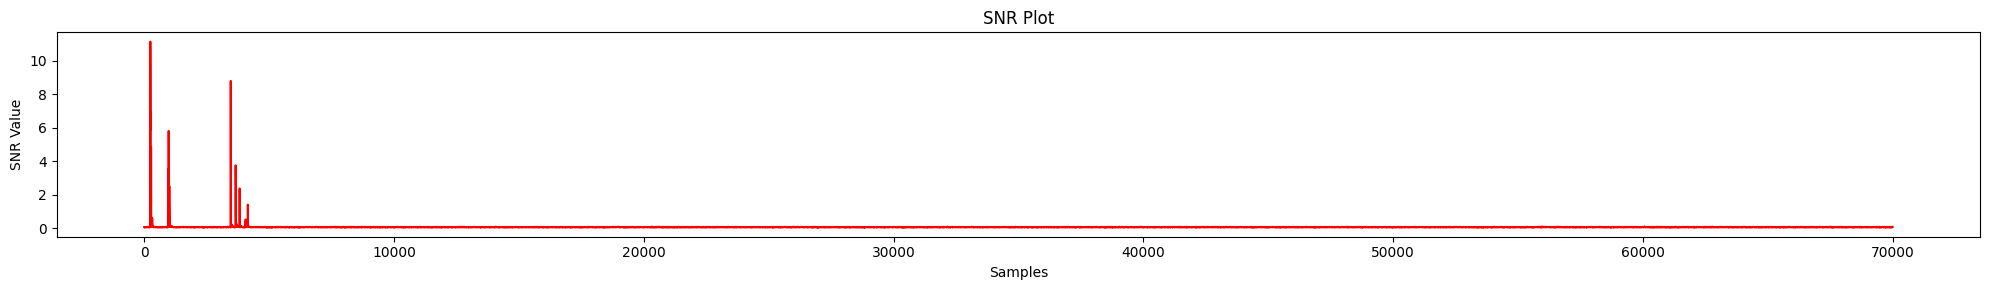

In [7]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit

# Welford's algorithm: Incrementally compute mean and variance
@njit
def welford_online(data):
    count = 0
    mean = np.zeros(data.shape[1])
    M2 = np.zeros(data.shape[1])

    for row in data:
        count += 1
        delta = row - mean
        mean += delta / count
        delta2 = row - mean
        M2 += delta * delta2
    
    variance = M2 / count if count > 1 else np.zeros(data.shape[1])
    return mean, variance


zarr_data = zarr.open('./benchmark_medium_sw_aes128_compressed.zarr', mode='r')
plaintext = zarr_data['0/0/plaintext'][:5000] 
traces = zarr_data['0/0/traces'][:5000]        
firstbyte = plaintext[:, 0]                   

num_samples = traces.shape[1]
num_categories = 256 
mean_values = np.zeros((num_categories, num_samples))
var_values = np.zeros((num_categories, num_samples))
category_counts = np.zeros(num_categories)

start_time = time.time()

for byte_value in range(num_categories):
    indices = (firstbyte == byte_value)
    if np.any(indices):
        selected_traces = traces[indices]
        mean_value, variance_value = welford_online(selected_traces)
        mean_values[byte_value] = mean_value
        var_values[byte_value] = variance_value
        category_counts[byte_value] = selected_traces.shape[0]


signal_mean, signal_variance = welford_online(mean_values[category_counts > 0])
signal = signal_variance


noise_mean, _ = welford_online(var_values[category_counts > 0])
noise = noise_mean  

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")

plt.figure(figsize=(20, 3))
plt.plot(signal, color='blue')
plt.title("Signal (Variance of Means)")
plt.xlabel("Samples")
plt.ylabel("Signal Value")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(noise, color='green')
plt.title("Noise (Mean of Variances)")
plt.xlabel("Samples")
plt.ylabel("Noise Value")
plt.tight_layout()
plt.show()

snr = np.where(noise != 0, signal / noise, 0)

plt.figure(figsize=(20, 3))
plt.plot(snr, color='red')
plt.title("SNR Plot")
plt.xlabel("Samples")
plt.ylabel("SNR Value")
plt.tight_layout()
plt.show()


Recovered Key Byte 0: 43 
Execution Time: 80.262513 seconds


C:\Users\lolo_\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


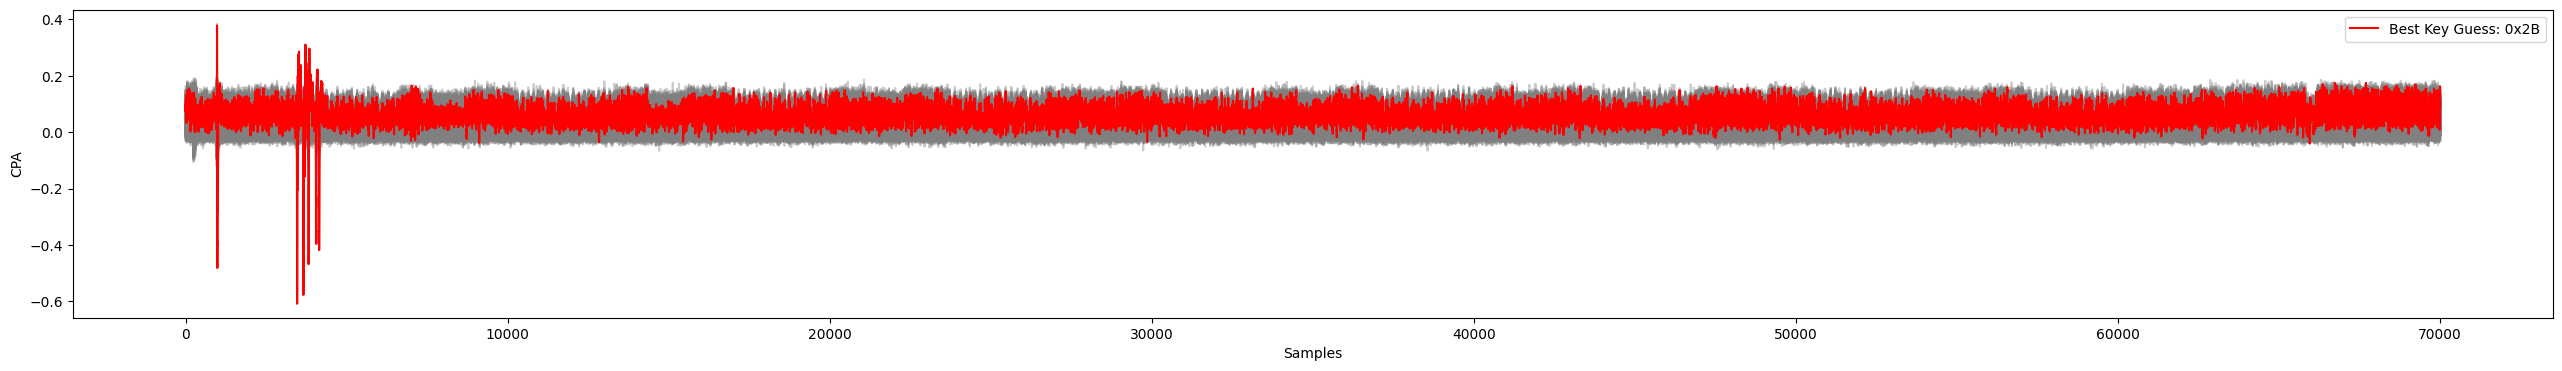

In [8]:
#one key byte
from numba import njit, prange
import numpy as np
import time
import matplotlib.pyplot as plt
import zarr


sbox = np.array([
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

@njit(parallel=True)
def compute_cpa_welford(traces, plaintext_column):
    n, num_samples = traces.shape
    num_hypotheses = 256
    cpa_results = np.zeros((num_hypotheses, num_samples), dtype=np.float64)

    for key_guess in prange(num_hypotheses):
        H = np.empty(n, dtype=np.float64)
        for i in range(n):
            H[i] = sbox[plaintext_column[i] ^ key_guess]

        # Initialize Welford algorithm
        meanH = 0.0
        M2H = 0.0
        covHT = np.zeros(num_samples, dtype=np.float64)
        meanT = np.zeros(num_samples, dtype=np.float64)
        M2T = np.zeros(num_samples, dtype=np.float64)

        for i in range(n):
            deltaH = H[i] - meanH
             # Calculate the difference between the current value and the mean
            meanH += deltaH / (i + 1)
            deltaH2 = H[i] - meanH
            M2H += deltaH * deltaH2

            for j in range(num_samples):
                deltaT = traces[i, j] - meanT[j]
                # Calculate the difference between the current sample point of the power trace and the mean
                meanT[j] += deltaT / (i + 1)
                deltaT2 = traces[i, j] - meanT[j]
                M2T[j] += deltaT * deltaT2
                covHT[j] += deltaH * deltaT

        for j in range(num_samples):
            numerator = covHT[j]
            denominator = np.sqrt(M2H * M2T[j])
            # If the denominator is not 0, calculate the SNR
            cpa_results[key_guess, j] = numerator / denominator if denominator != 0 else 0.0

    return cpa_results

def main():
    zarr_data = zarr.open('./benchmark_medium_sw_aes128_compressed.zarr', mode='r')
    plaintext = zarr_data['0/0/plaintext'][:5000]
    traces = zarr_data['0/0/traces'][:5000]
    byte_index = 0
    plaintext_column = plaintext[:, byte_index]

    start_time = time.time()
    cpa_results = compute_cpa_welford(traces, plaintext_column)
    end_time = time.time()

    execution_time = end_time - start_time
    best_key_guess = np.argmax(np.max(np.abs(cpa_results), axis=1))

    print(f"Recovered Key Byte {byte_index}: {best_key_guess} ")
    print(f"Execution Time: {execution_time:.6f} seconds")

    fig, ax = plt.subplots(figsize=(32, 4))
    for key_guess in range(256):
        ax.plot(cpa_results[key_guess], color='gray', alpha=0.4)
    ax.plot(cpa_results[best_key_guess], color='red', label=f"Best Key Guess: 0x{best_key_guess:02X}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("CPA")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()


Execution Time: 57.258141 seconds


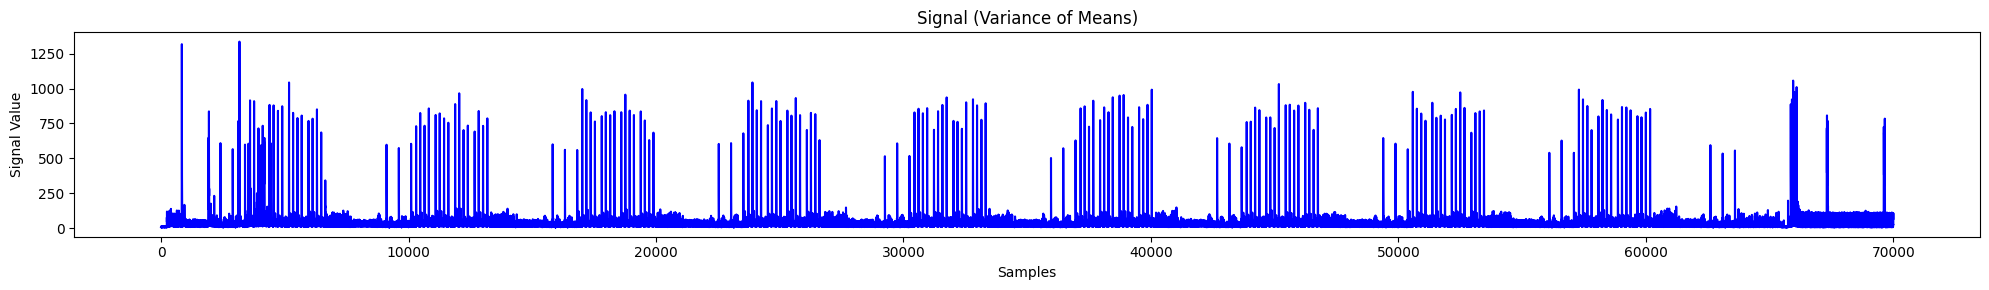

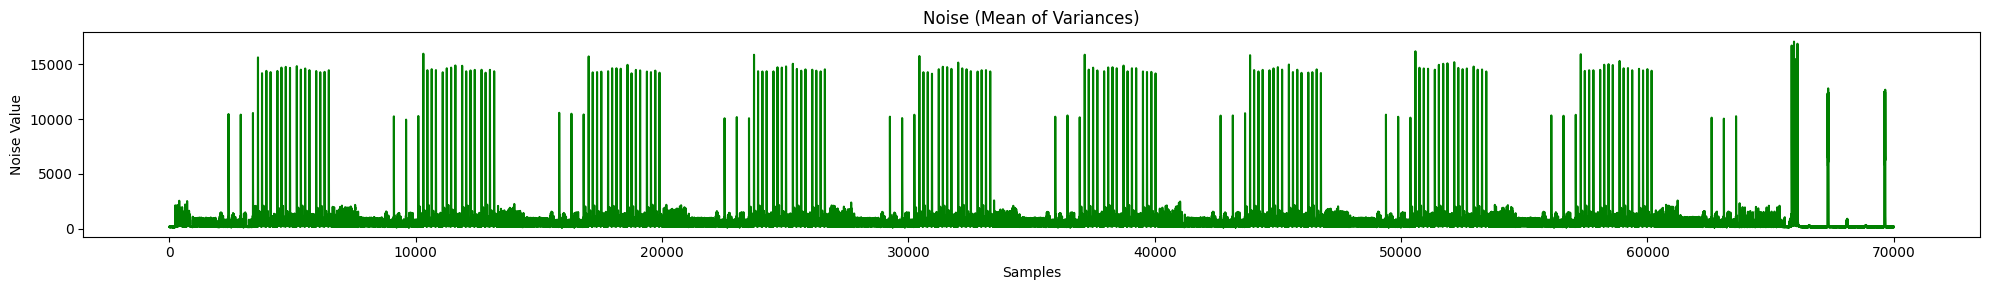

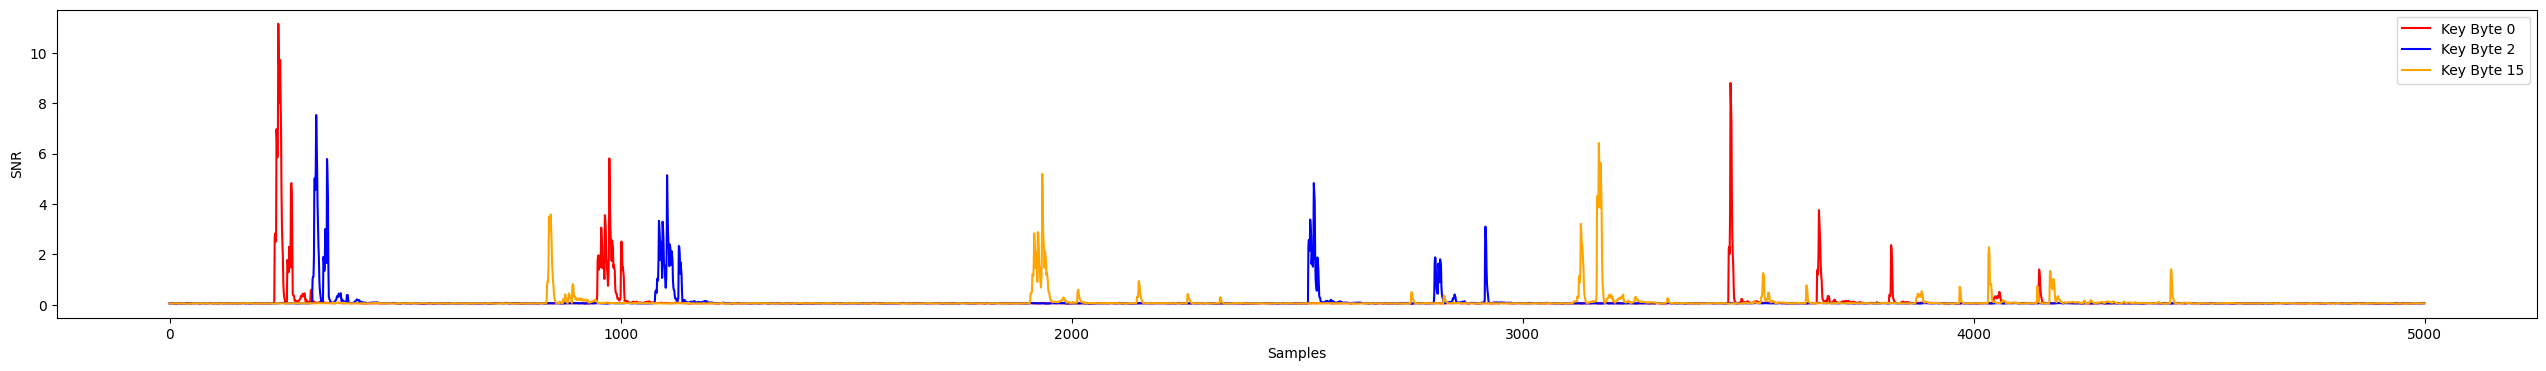

In [9]:
#all key bytes 
import zarr
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit

# Welford's algorithm: Incrementally compute mean and variance
@njit
def welford_online(data):
    count = 0
    mean = np.zeros(data.shape[1])
    M2 = np.zeros(data.shape[1])

    for row in data:
        count += 1
        delta = row - mean
        mean += delta / count
        delta2 = row - mean
        M2 += delta * delta2
    # Compute variance, avoid division by zero
    variance = M2 / count if count > 1 else np.zeros(data.shape[1])
    return mean, variance

zarr_data = zarr.open('./benchmark_medium_sw_aes128_compressed.zarr', mode='r')
plaintext = zarr_data['0/0/plaintext'][:5000]  
traces = zarr_data['0/0/traces'][:5000]        

num_samples = traces.shape[1]
num_categories = 256  
num_key_bytes = 16  

snr_values = np.zeros((num_key_bytes, num_samples))

start_time = time.time()

for key_byte in range(num_key_bytes):
    byte_values = plaintext[:, key_byte]

    mean_values = np.zeros((num_categories, num_samples))
    var_values = np.zeros((num_categories, num_samples))
    category_counts = np.zeros(num_categories)

    for byte_value in range(num_categories):
        indices = (byte_values == byte_value)
        if np.any(indices):
            selected_traces = traces[indices]
            mean_value, variance_value = welford_online(selected_traces)
            mean_values[byte_value] = mean_value
            var_values[byte_value] = variance_value
            category_counts[byte_value] = selected_traces.shape[0]

    signal_mean, signal_variance = welford_online(mean_values[category_counts > 0])
    signal = signal_variance
    noise_mean, _ = welford_online(var_values[category_counts > 0])
    noise = noise_mean
    snr = np.where(noise != 0, signal / noise, 0)

    snr_values[key_byte] = snr

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")

plt.figure(figsize=(20, 3))
plt.plot(signal, color='blue')
plt.title("Signal (Variance of Means)")
plt.xlabel("Samples")
plt.ylabel("Signal Value")
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(noise, color='green')
plt.title("Noise (Mean of Variances)")
plt.xlabel("Samples")
plt.ylabel("Noise Value")
plt.tight_layout()
plt.show()

selected_bytes = [0, 2, 15]  
colors = ['red', 'blue', 'orange']

fig, ax = plt.subplots(figsize=(32, 4))
for i, key_byte in enumerate(selected_bytes):
    ax.plot(snr_values[key_byte, 0:5000], color=colors[i], label=f'Key Byte {key_byte}')
ax.set_xlabel('Samples')
ax.set_ylabel('SNR')
ax.legend()
plt.show()


Recovered Key Byte 0: 43
Recovered Key Byte 1: 126
Recovered Key Byte 2: 21
Recovered Key Byte 3: 22
Recovered Key Byte 4: 40
Recovered Key Byte 5: 174
Recovered Key Byte 6: 210
Recovered Key Byte 7: 166
Recovered Key Byte 8: 171
Recovered Key Byte 9: 247
Recovered Key Byte 10: 21
Recovered Key Byte 11: 136
Recovered Key Byte 12: 9
Recovered Key Byte 13: 207
Recovered Key Byte 14: 79
Recovered Key Byte 15: 60
Execution Time: 722.701316 seconds


C:\Users\lolo_\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


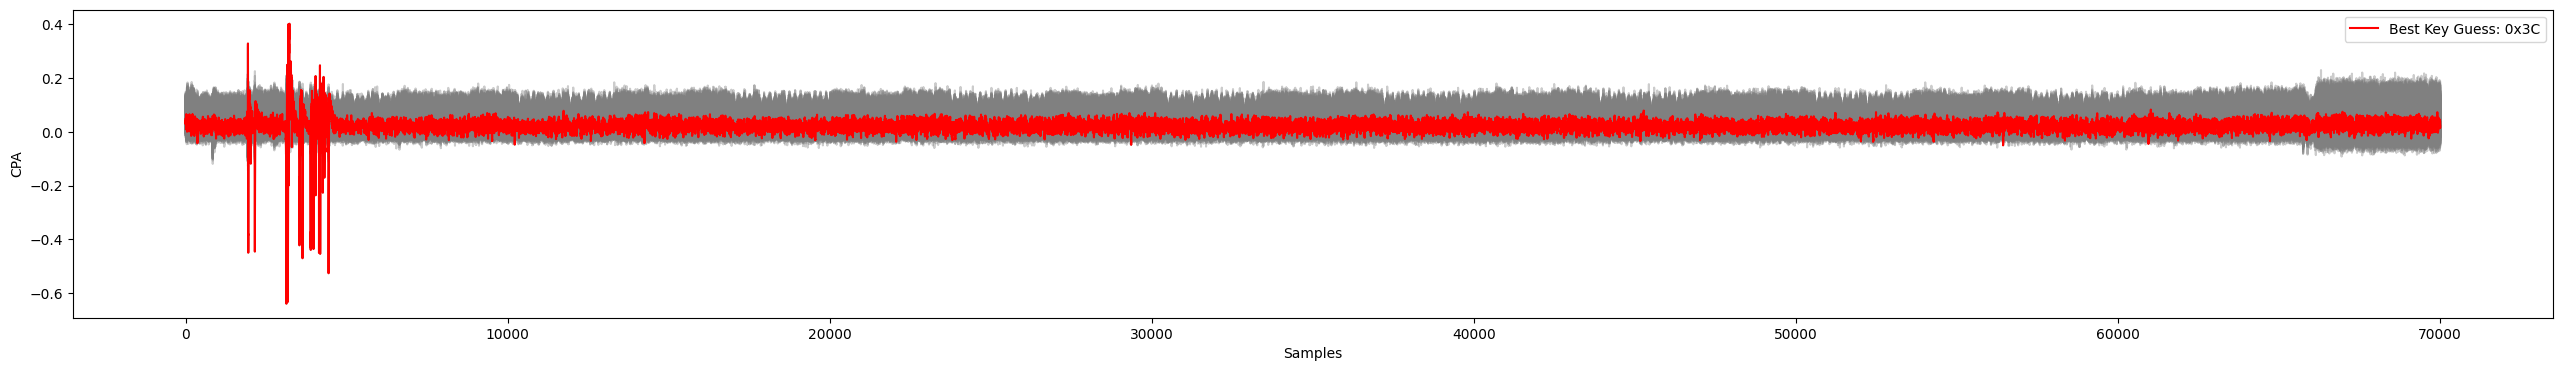

In [10]:
#all key bytes
from numba import njit, prange
import numpy as np
import time
import matplotlib.pyplot as plt
import zarr


sbox = np.array([
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

@njit(parallel=True)
def compute_cpa_welford(traces, plaintext_column):
    n, num_samples = traces.shape
    num_hypotheses = 256
    cpa_results = np.zeros((num_hypotheses, num_samples), dtype=np.float64)

    for key_guess in prange(num_hypotheses):
        H = np.empty(n, dtype=np.float64)
        for i in range(n):
            H[i] = sbox[plaintext_column[i] ^ key_guess]

        meanH = 0.0
        M2H = 0.0
        covHT = np.zeros(num_samples, dtype=np.float64)
        meanT = np.zeros(num_samples, dtype=np.float64)
        M2T = np.zeros(num_samples, dtype=np.float64)

        for i in range(n):
            deltaH = H[i] - meanH
            meanH += deltaH / (i + 1)
            deltaH2 = H[i] - meanH
            M2H += deltaH * deltaH2

            for j in range(num_samples):
                deltaT = traces[i, j] - meanT[j]
                meanT[j] += deltaT / (i + 1)
                deltaT2 = traces[i, j] - meanT[j]
                M2T[j] += deltaT * deltaT2
                covHT[j] += deltaH * deltaT

        for j in range(num_samples):
            numerator = covHT[j]
            denominator = np.sqrt(M2H * M2T[j])
            cpa_results[key_guess, j] = numerator / denominator if denominator != 0 else 0.0

    return cpa_results

def main():
    zarr_data = zarr.open('./benchmark_medium_sw_aes128_compressed.zarr', mode='r')
    plaintext = zarr_data['0/0/plaintext'][:5000]
    traces = zarr_data['0/0/traces'][:5000]
    key_guesses = []
    start_time = time.time()

    for byte_index in range(16):
        plaintext_column = plaintext[:, byte_index]
        cpa_results = compute_cpa_welford(traces, plaintext_column)
        best_key_guess = np.argmax(np.max(np.abs(cpa_results), axis=1))
        key_guesses.append(best_key_guess)

        print(f"Recovered Key Byte {byte_index}: {best_key_guess}")

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time:.6f} seconds")

    
    fig, ax = plt.subplots(figsize=(32, 4))
    for key_guess in range(256):
        ax.plot(cpa_results[key_guess], color='gray', alpha=0.4)
    ax.plot(cpa_results[best_key_guess], color='red', label=f"Best Key Guess: 0x{best_key_guess:02X}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("CPA")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()
